# **Dataset**

PubMed 200k RCT dataset

Data is availably publically and for free in the form of .txt files on GitHub.
https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 29.11 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [2]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Looking at the README file from the GitHub page:



1.   PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
2.   PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. PubMed_20k_RCT_numbers_replaced_with_at_sign).
3.   Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.


To start, dataset - PubMed_20k_RCT_numbers_replaced_with_at_sign.



In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
import os
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

print(os.listdir(data_dir))

['train.txt', 'dev.txt', 'test.txt']


# **Preprocessing Data**

In [5]:
def get_lines(file):
  with open(file, "r") as f:
    return f.readlines()

In [6]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def preprocess_text(file):
  """
  [......,
  {"target": 'RESULTS',
        "text": There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .",
        "line_number": 7,
        "total_lines": 9},
        .......]

        """
  input_lines = get_lines(file)
  abstract_lines = ""
  abstract_samples = []

  # Loop through each line
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()

      # Loop through each line in abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [8]:
train_samples = preprocess_text(data_dir + "train.txt")
val_samples = preprocess_text(data_dir + "dev.txt")
test_samples = preprocess_text(data_dir + "test.txt")

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180040 entries, 0 to 180039
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   target       180040 non-null  object
 1   text         180040 non-null  object
 2   line_number  180040 non-null  int64 
 3   total_lines  180040 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.5+ MB


In [11]:
train_df.columns

Index(['target', 'text', 'line_number', 'total_lines'], dtype='object')

In [12]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

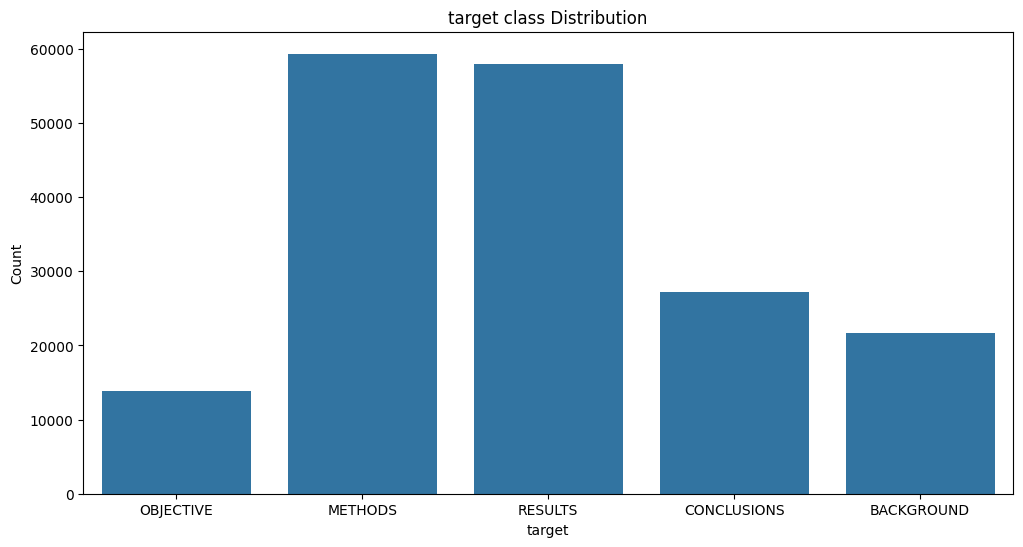

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='target',data=train_df)
plt.title('target class Distribution')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='total_lines', ylabel='Count'>

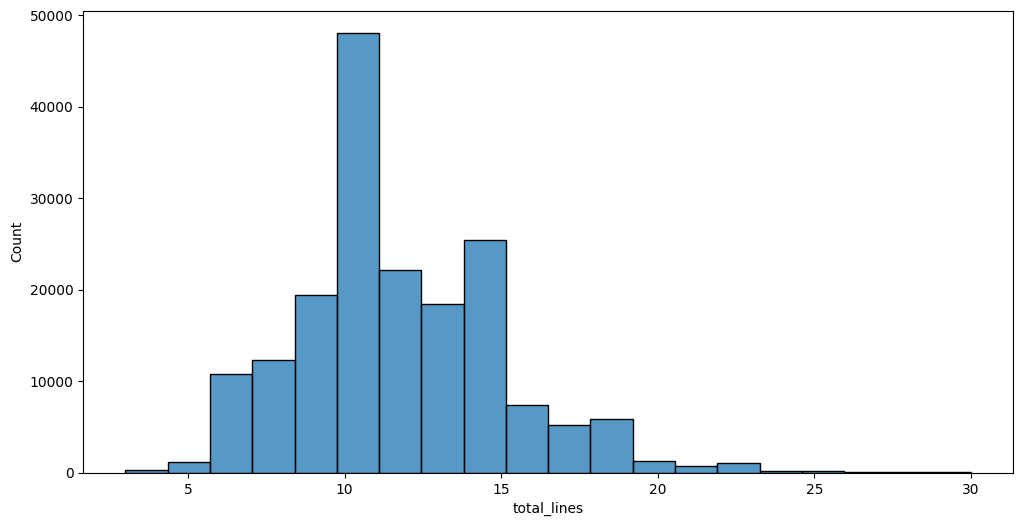

In [14]:
# Plot the 'total_lines'
plt.figure(figsize=(12, 6))
sns.histplot(x='total_lines',data=train_df,bins=20)


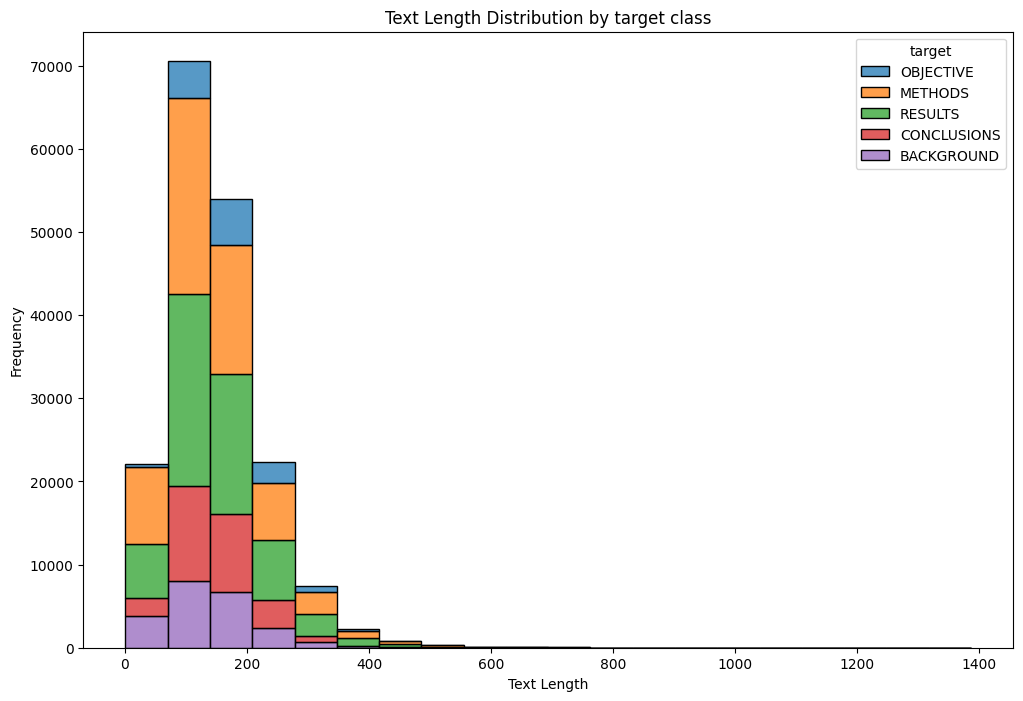

In [15]:
train_df_plt = train_df.copy()
train_df_plt['text_length'] = train_df_plt['text'].apply(len)

# Plot text length distribution for each class
plt.figure(figsize=(12, 8))
sns.histplot(data=train_df_plt, x='text_length', hue='target', multiple='stack',bins=20)
plt.title('Text Length Distribution by target class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


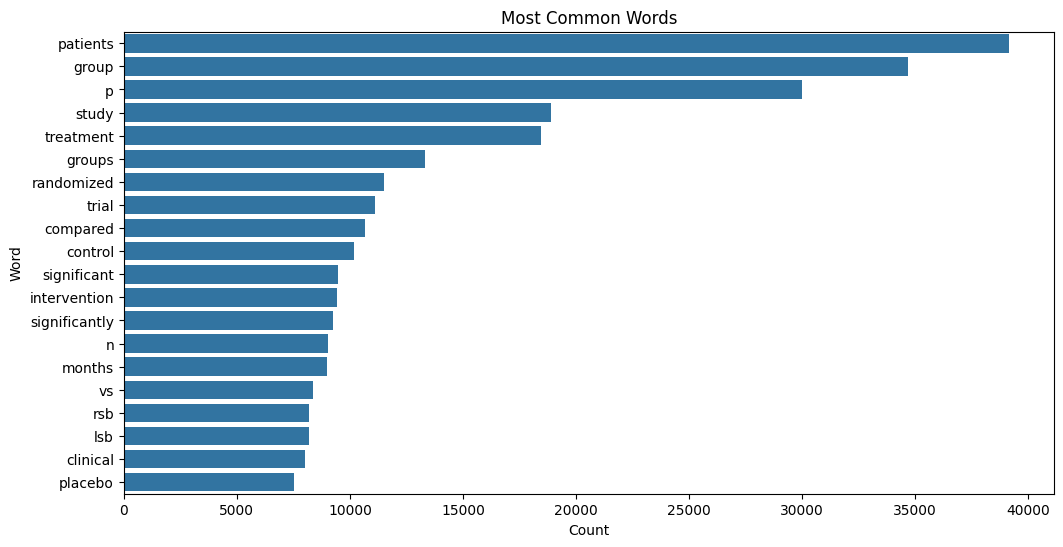

In [16]:
import nltk
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords
import string

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Clean the text data
train_df_plt['cleaned_text'] = train_df_plt['text'].apply(clean_text)

# Combine all text data
all_text = ' '.join(train_df_plt['cleaned_text'])

# Tokenize the text
words = all_text.split()

# Remove stopwords
stop_words = set(stopwords.words('english')) # This line should now work after downloading the corpus
words = [word for word in words if word not in stop_words]

# Get the most common words
common_words = Counter(words).most_common(20)

# Convert to DataFrame for plotting
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=common_words_df)
plt.title('Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

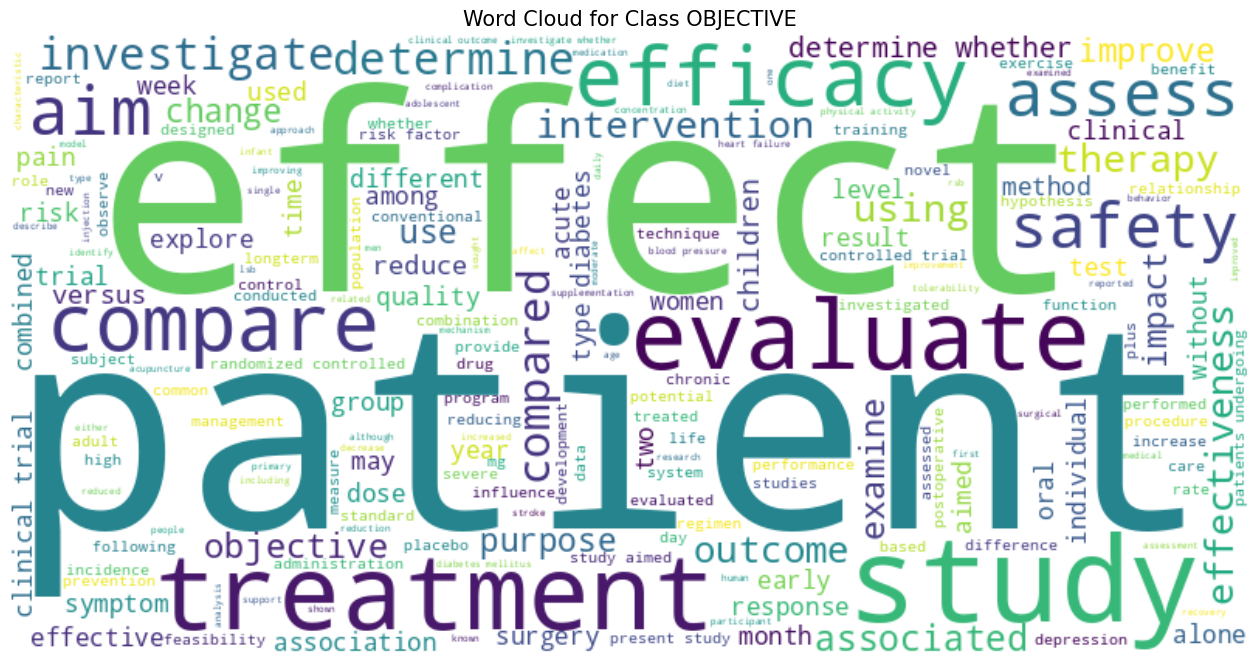

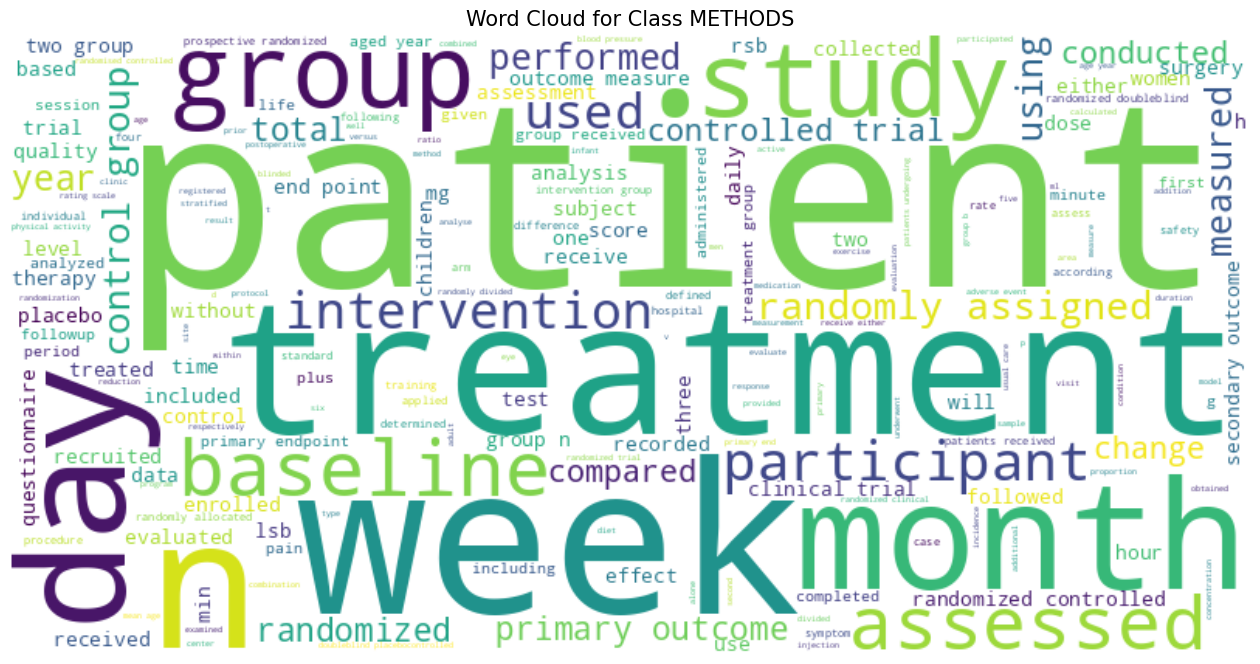

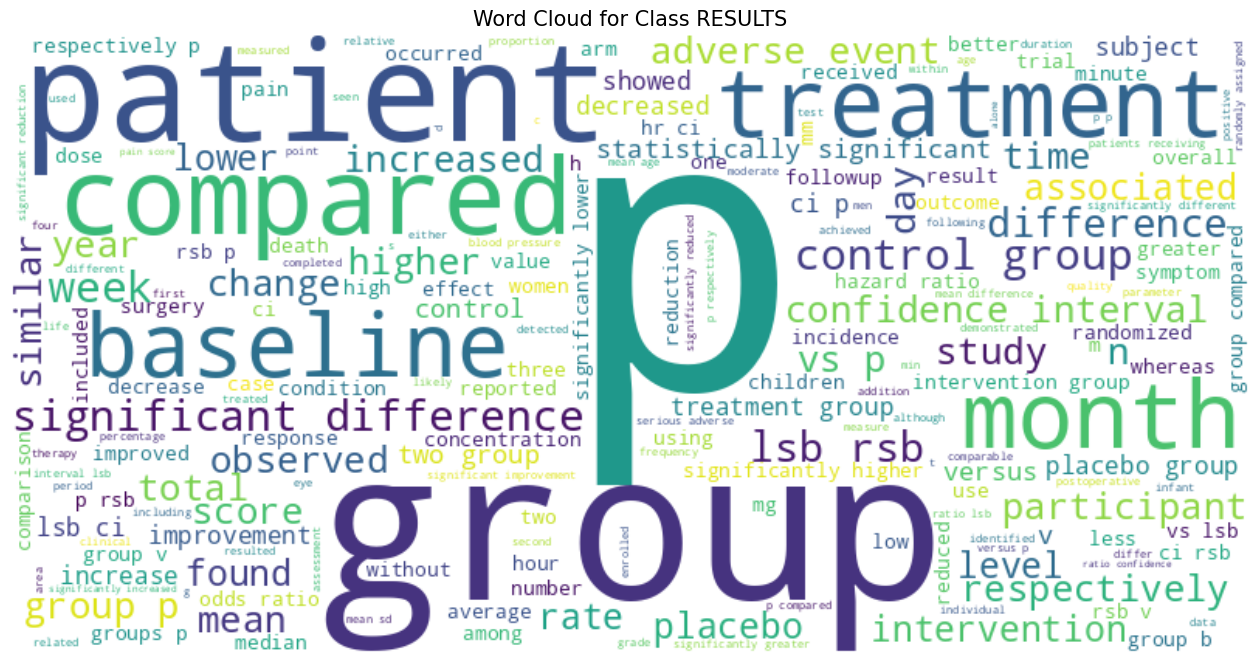

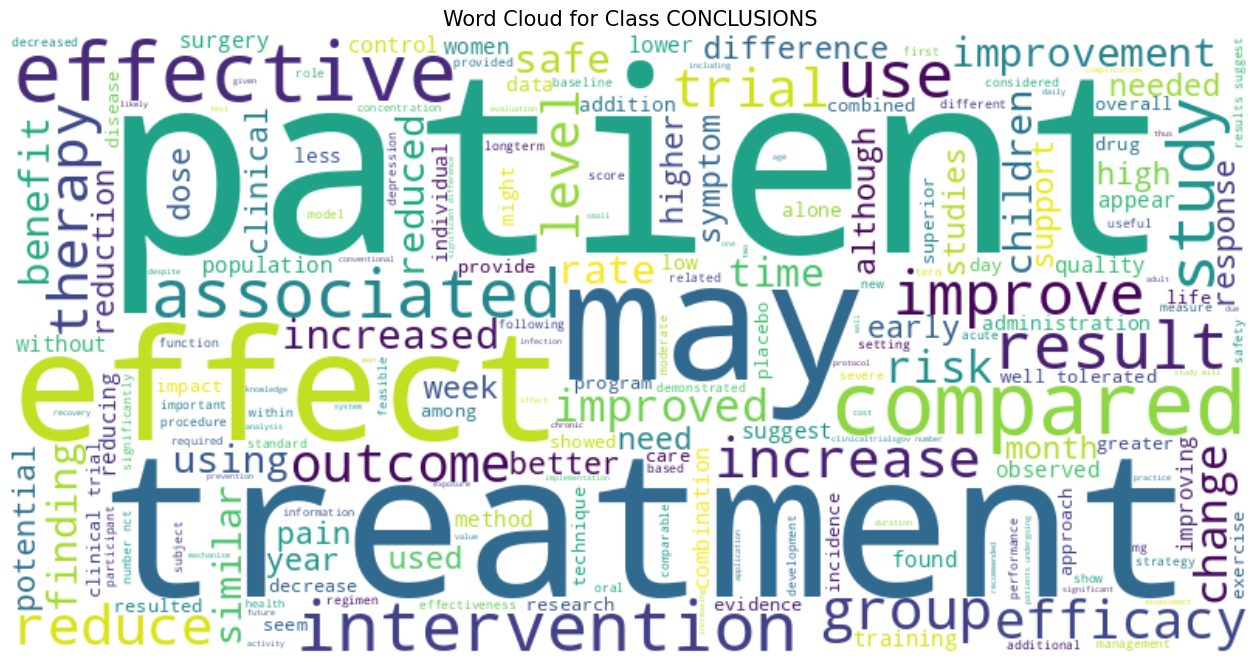

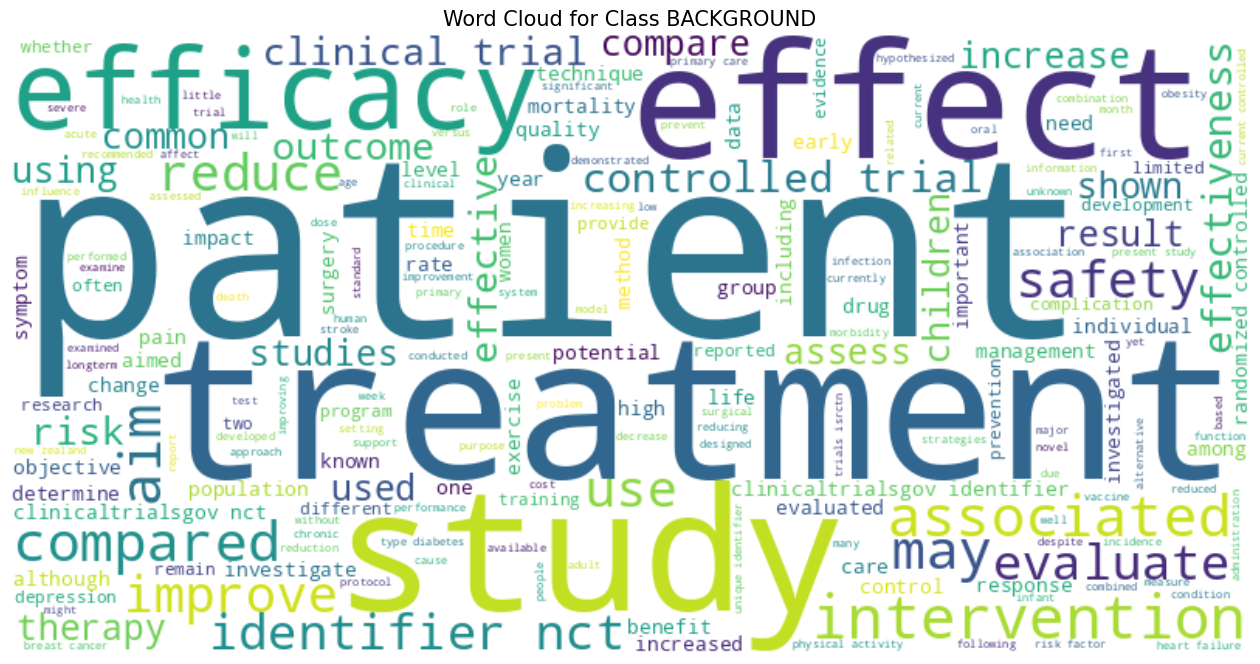

In [17]:
from wordcloud import WordCloud

# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(16, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Generate word cloud for each class
for cls in train_df_plt['target'].unique():
    class_text = ' '.join(train_df_plt[train_df_plt['target'] == cls]['cleaned_text'])
    generate_wordcloud(class_text, f'Word Cloud for Class {cls}')


One hot encode and label encode the targets

In [18]:
# one hot encoding the labels
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
train_labels_onehot = onehot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_onehot = onehot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_onehot = onehot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))


# Label encoding the labels
label_encoder = LabelEncoder()
train_labels_encoder = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoder = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoder = label_encoder.transform(test_df['target'].to_numpy())

In [19]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
import tensorflow as tf
from tensorflow.keras import layers


In [21]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [22]:
import numpy as np
sentence_len = [len(sentence.split()) for sentence in train_sentences]
sen_cover = int(np.percentile(sentence_len, 95))
sen_cover

55

In [23]:
# Create text vectorizer
# PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000

max_tokens = 68000

from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

text_vectorizer.adapt(train_sentences)

In [24]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab)

64841

In [25]:
#custom text embedding


# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                   output_dim=128,
                                   mask_zero=True,
                                   name="token_embedding")

In [26]:
# Turn  data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_onehot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_onehot))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# **Conv1D with token embeddings (Model 1)**

In [27]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [28]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

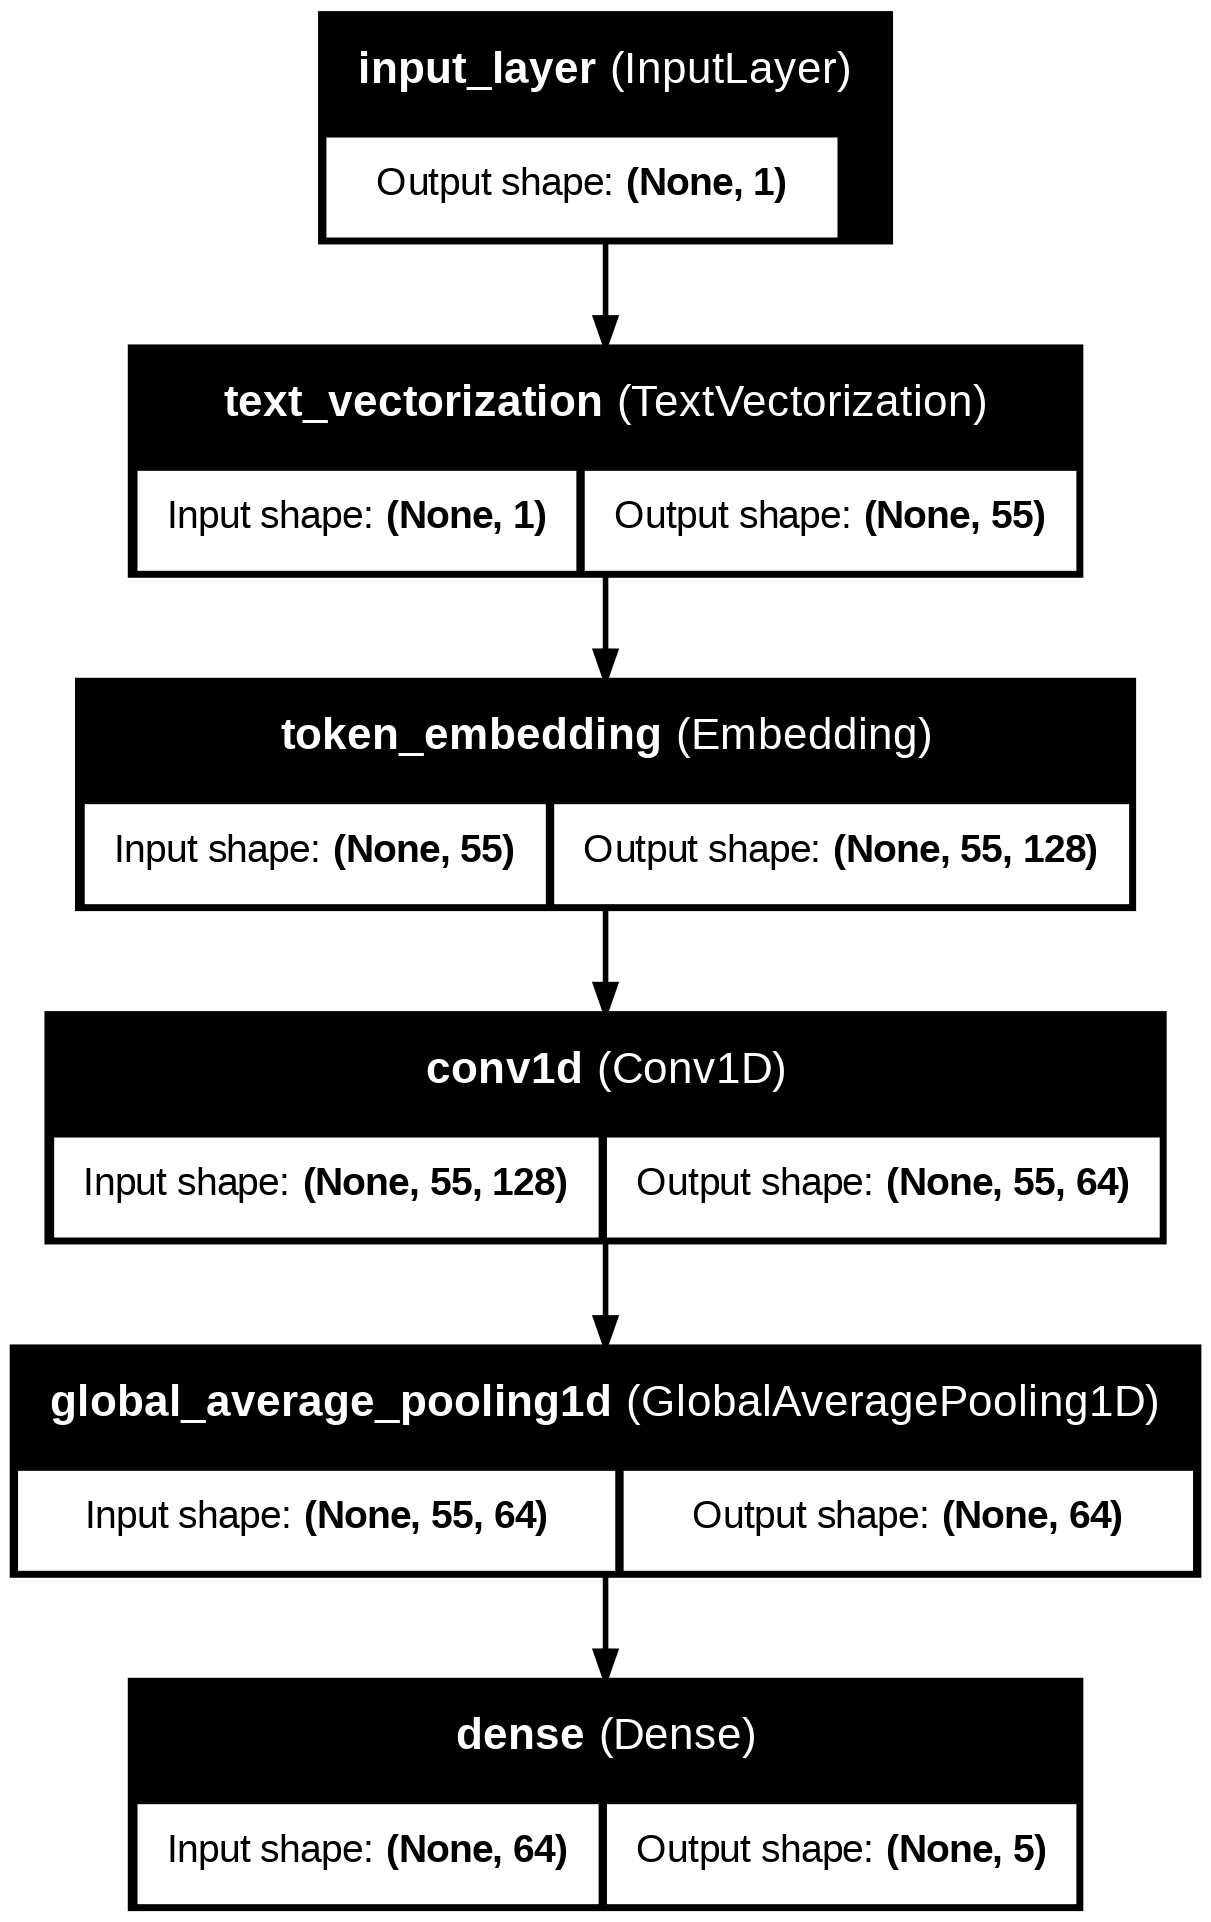

In [29]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image


plot_model(model_1, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image inline in the notebook
Image(filename='model.png')


In [30]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5288 - loss: 1.1560 - val_accuracy: 0.7367 - val_loss: 0.6946
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7461 - loss: 0.6869 - val_accuracy: 0.7640 - val_loss: 0.6317
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7675 - loss: 0.6258 - val_accuracy: 0.7909 - val_loss: 0.5908


In [31]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7857 - loss: 0.5968


[0.5987180471420288, 0.786310076713562]

In [32]:
model_1_pred_probs = model_1.predict(valid_dataset)


# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)


945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [34]:
model_1_results = calculate_results(y_true=val_labels_encoder,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.63100754667019,
 'precision': 0.7825800470671647,
 'recall': 0.786310075466702,
 'f1': 0.783878513978757}

# **Conv1D with character embeddings (Model 2)**

In [35]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [36]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [37]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

<Axes: ylabel='Count'>

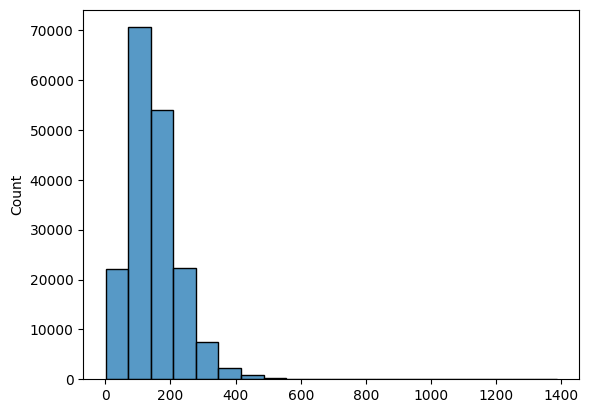

In [38]:
sns.histplot(char_lens,bins=20)

In [39]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [40]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [41]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [42]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False,
                              name="char_embed")

In [43]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_conv1D_char_embedding")

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
model_2.summary()

Model: "model_2_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

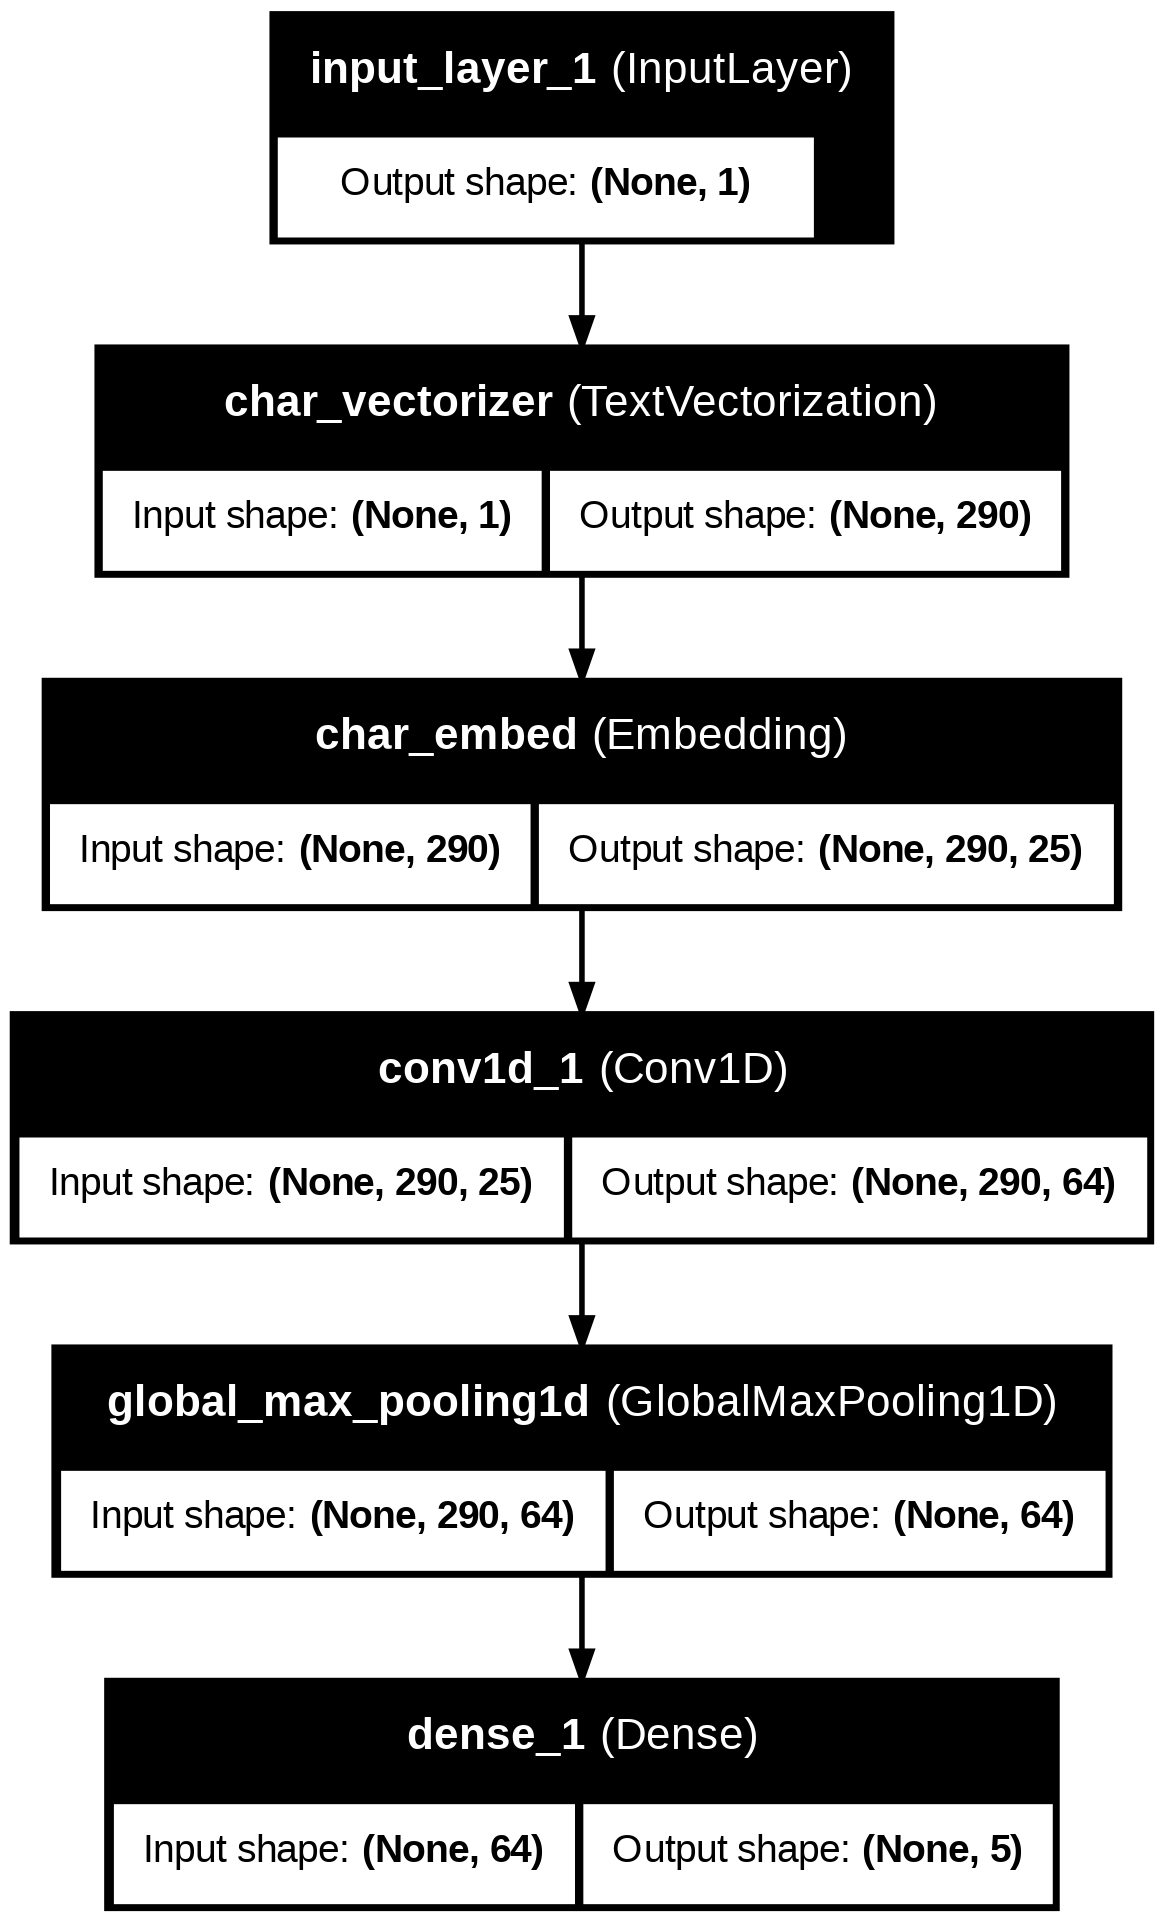

In [45]:
plot_model(model_2, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image inline in the notebook
Image(filename='model.png')

In [46]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)




In [47]:
# Fit the model on chars only
model_2_history = model_2.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4383 - loss: 1.3801 - val_accuracy: 0.5678 - val_loss: 1.0604
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5712 - loss: 1.0589 - val_accuracy: 0.6137 - val_loss: 0.9728
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6181 - loss: 0.9663 - val_accuracy: 0.6413 - val_loss: 0.9148


In [48]:
# Evaluate model_3 on whole validation char dataset
model_2.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6415 - loss: 0.9115


[0.9198537468910217, 0.6389845013618469]

In [49]:
# Make predictions with character model only
model_2_pred_probs = model_2.predict(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [50]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

In [51]:
model_2_results = calculate_results(y_true=val_labels_encoder,
                                        y_pred=model_2_preds)
model_2_results

{'accuracy': 63.89845094664371,
 'precision': 0.6446642098878304,
 'recall': 0.6389845094664371,
 'f1': 0.6295446380028339}

# **Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings (Model 3)**

<Axes: xlabel='line_number', ylabel='Count'>

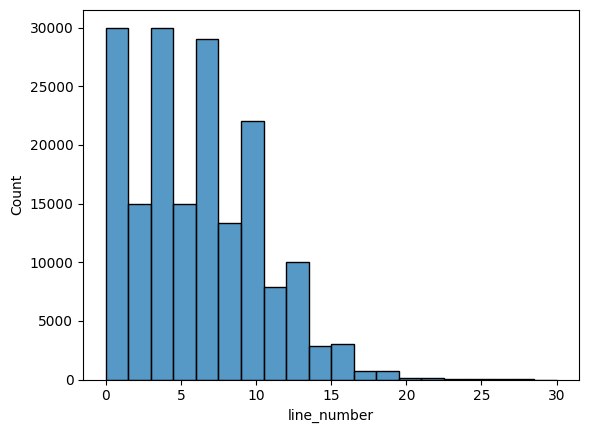

In [52]:
sns.histplot(train_df.line_number,bins=20)

In [53]:
# Use TensorFlow to create one-hot-encoded tensors of  "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

<Axes: xlabel='total_lines', ylabel='Count'>

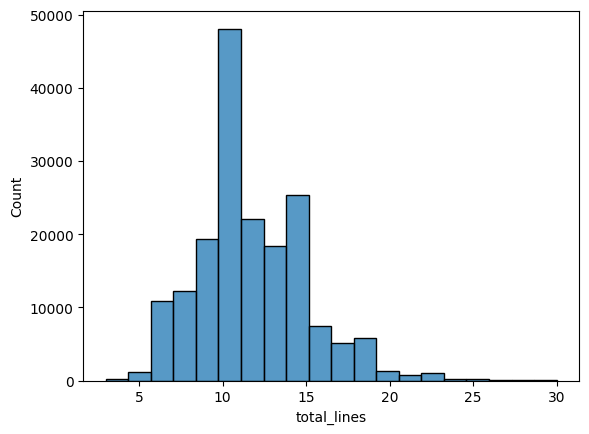

In [54]:
sns.histplot(train_df.total_lines,bins=20)

In [55]:
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [56]:
# Use TensorFlow to create one-hot-encoded tensors of  "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [62]:
import tensorflow_hub as hub # Import tensorflow_hub
from tensorflow.keras import layers # Import layers from tensorflow.keras

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")

# Wrap the hub layer in a Lambda layer to handle KerasTensor
# Specify the output shape for the Lambda layer
tf_hub_embedding_layer = layers.Lambda(lambda x: hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                              trainable=False,
                                                              name="universal_sentence_encoder")(x),
                                       output_shape=(512,) # Output shape of the USE layer
                                       )(token_inputs)

token_outputs = layers.Dense(128, activation="relu")(tf_hub_embedding_layer)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_3 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [64]:
model_3.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,750 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         65,664 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         14,848 │ char_embed[3][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 192)            │              0 │ dense_10[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 256)            │         49,408 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 32)             │            512 │ line_number_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 32)             │            672 │ total_lines_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_positional_em… │ (None, 320)            │              0 │ dense_11[0][0],        │
│ (Concatenate)             │                        │                │ dense_12[0][0],        │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 5)              │          1,605 │ token_char_positional… │
└──────────────────────

 Total params: 134,459 (525.23 KB)

 Trainable params: 134,459 (525.23 KB)

 Non-trainable params: 0 (0.00 B)

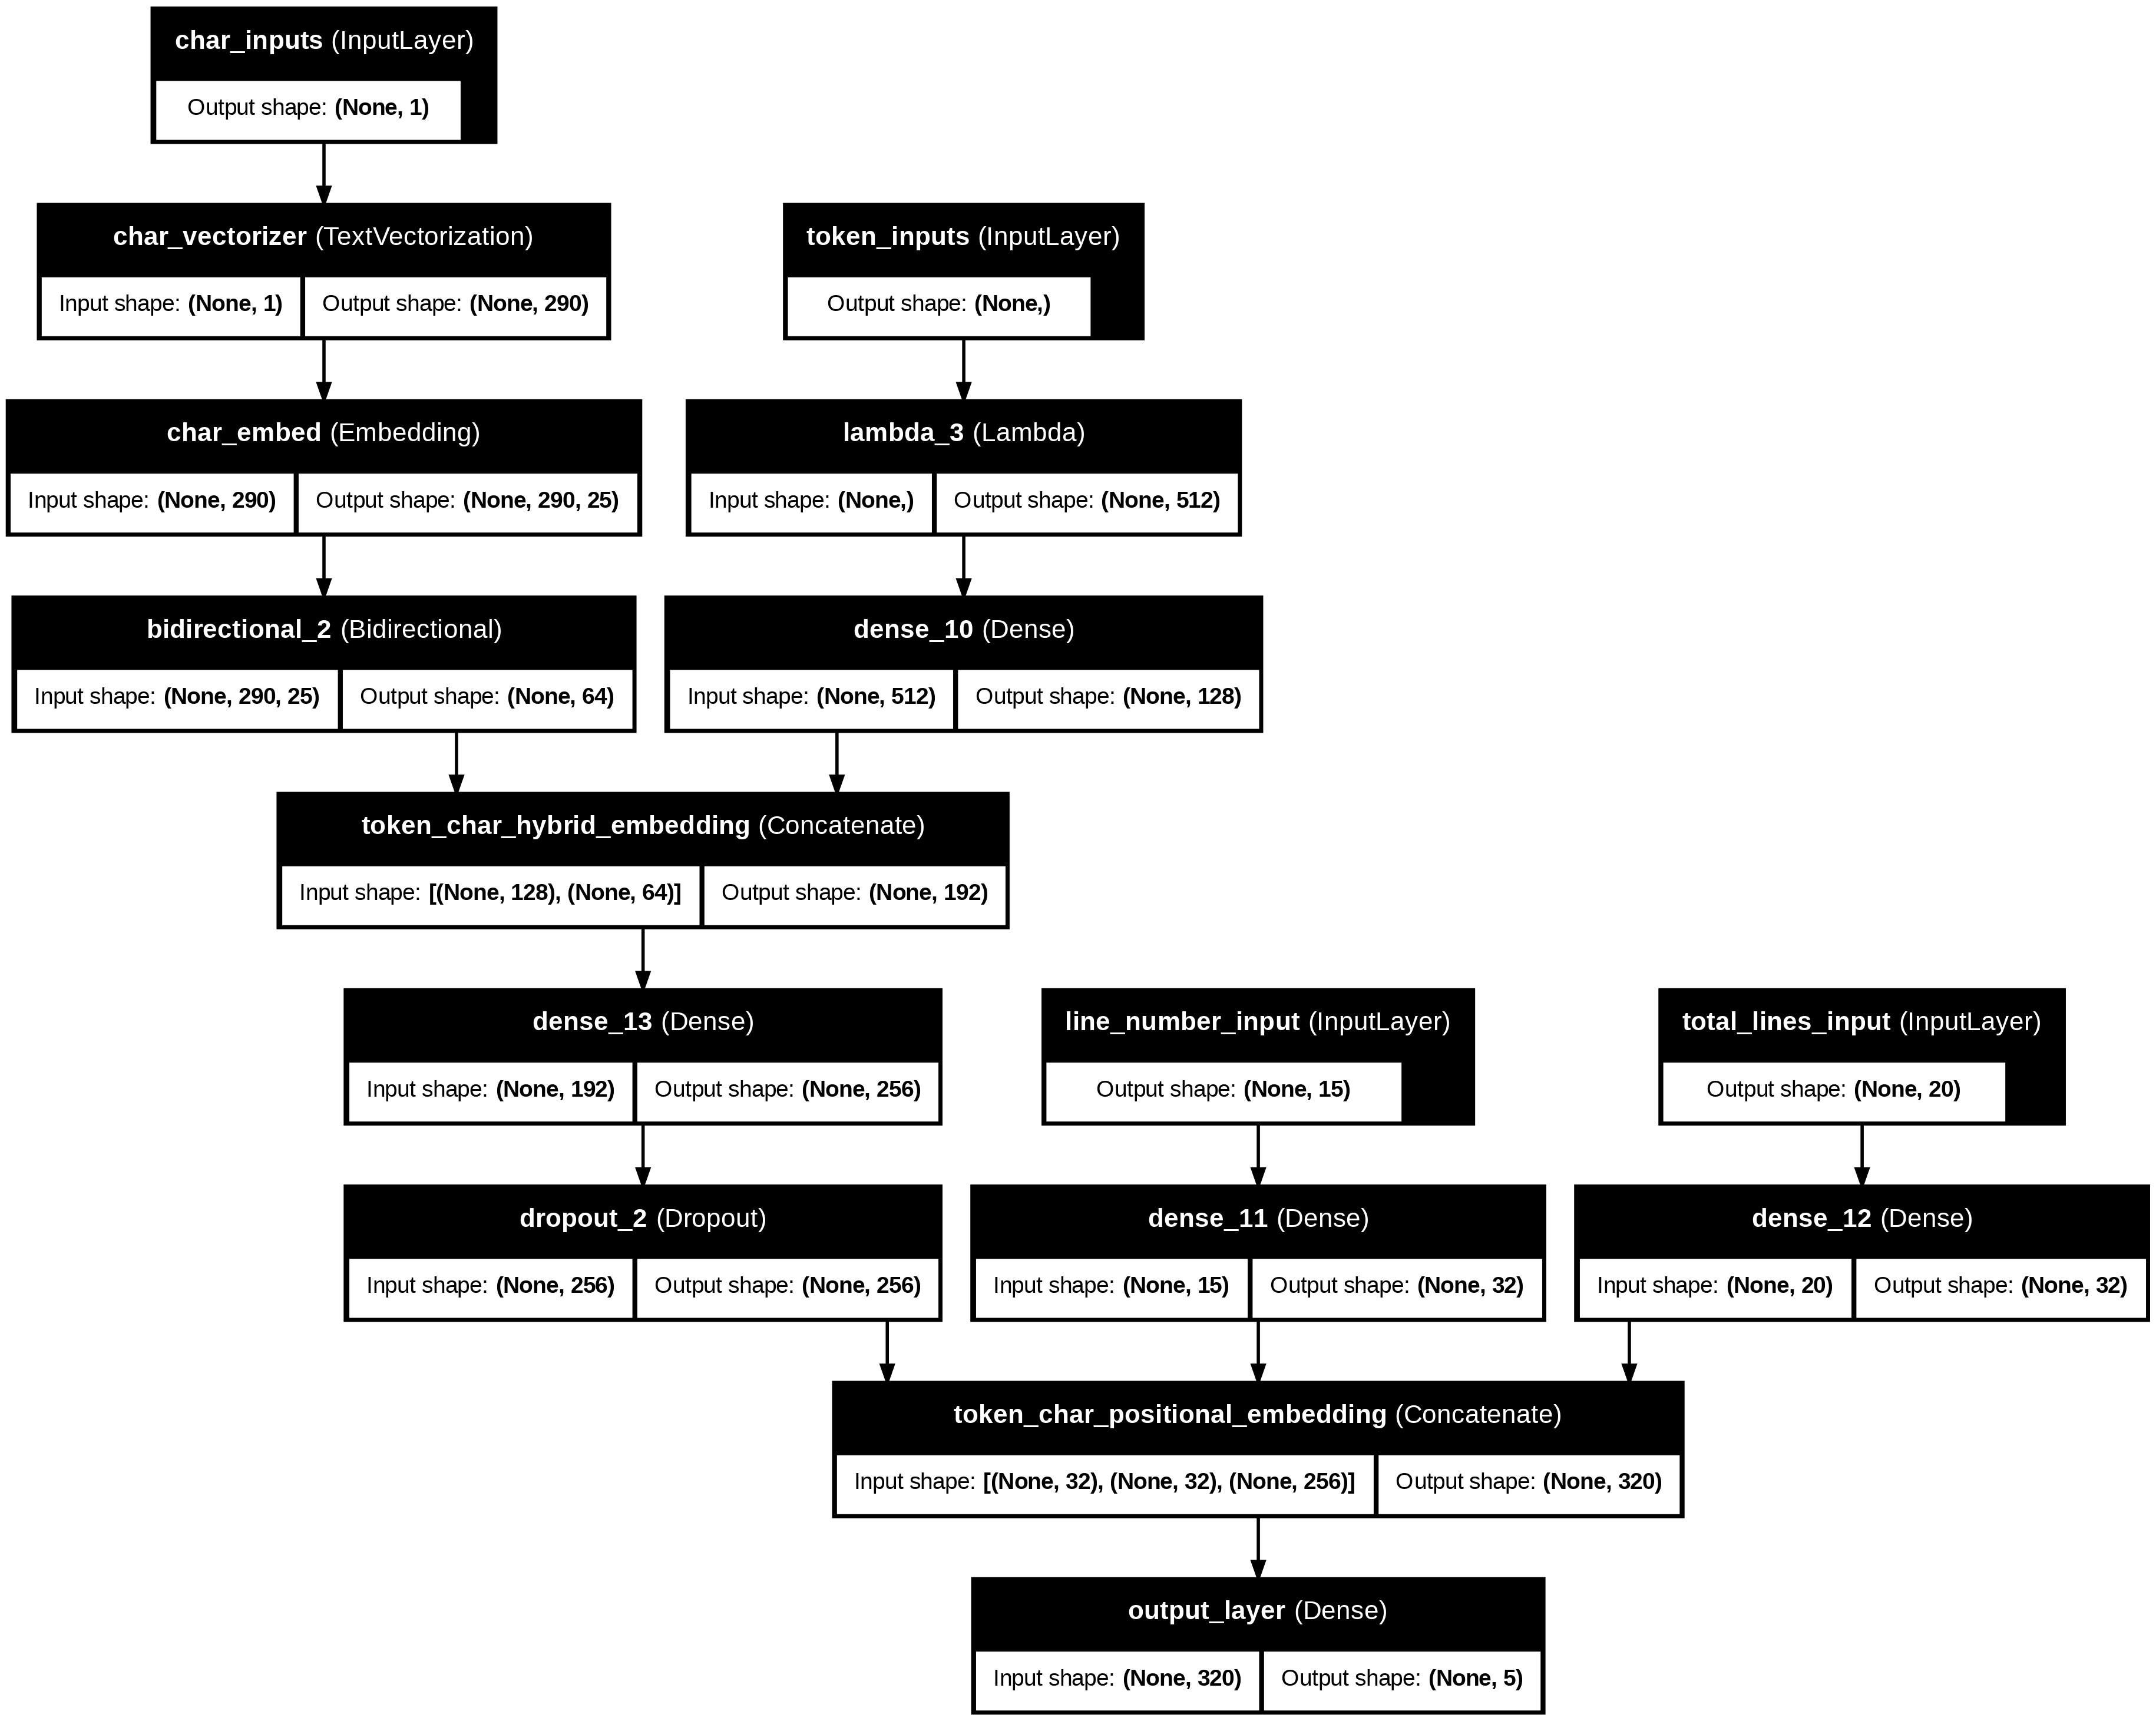

In [65]:
plot_model(model_3, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image inline in the notebook
Image(filename='model.png')

In [66]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately



In [70]:
# Fit the token, char and positional embedding model
history_model_3 = model_3.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - accuracy: 0.6224 - loss: 1.2289 - val_accuracy: 0.8019 - val_loss: 0.9845
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8110 - loss: 0.9742 - val_accuracy: 0.8198 - val_loss: 0.9427
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.8207 - loss: 0.9549 - val_accuracy: 0.8305 - val_loss: 0.9353


In [72]:
# Make predictions with token-char-positional hybrid model
model_3_pred_probs = model_3.predict(val_pos_char_token_dataset, verbose=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step


In [74]:
# Turn prediction probabilities into prediction classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

In [75]:
# Calculate results of token-char-positional hybrid model
model_3_results = calculate_results(y_true=val_labels_encoder,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 83.44035482589699,
 'precision': 0.8332207288313939,
 'recall': 0.8344035482589699,
 'f1': 0.8332187586725208}

# **Compare model results**

In [97]:
all_model_results = pd.DataFrame({"token_embed_conv1d": model_1_results,
                                  "char_embed_conv1d": model_2_results,
                                  "tribrid_pos_char_token_embed": model_3_results})
all_model_results = all_model_results.transpose()
all_model_results

accuracy  precision    recall        f1
token_embed_conv1d            78.631008   0.782580  0.786310  0.783879
char_embed_conv1d             63.898451   0.644664  0.638985  0.629545
tribrid_pos_char_token_embed  83.440355   0.833221  0.834404  0.833219

In [98]:
all_model_results['Model'] = all_model_results.index
all_model_results["accuracy"] = all_model_results["accuracy"]/100


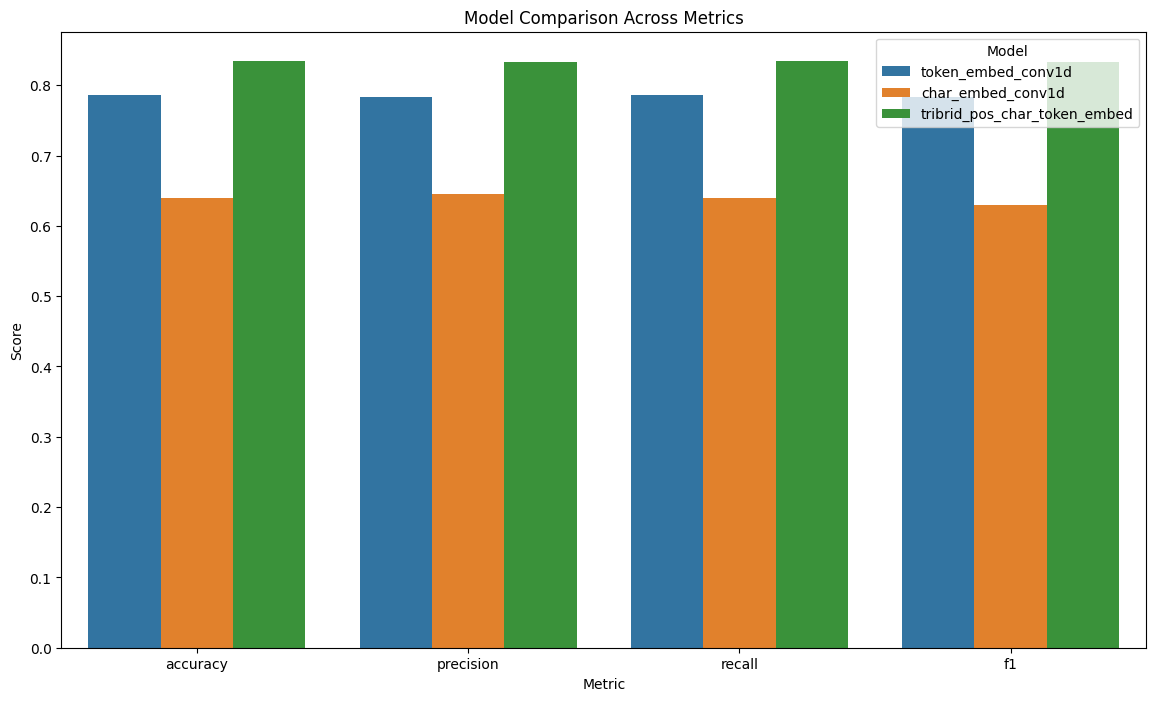

In [99]:

plt.figure(figsize=(14, 8))


all_model_results_long = all_model_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(x="Metric", y="Score", hue="Model", data=all_model_results_long)


plt.title('Model Comparison Across Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')

plt.show()


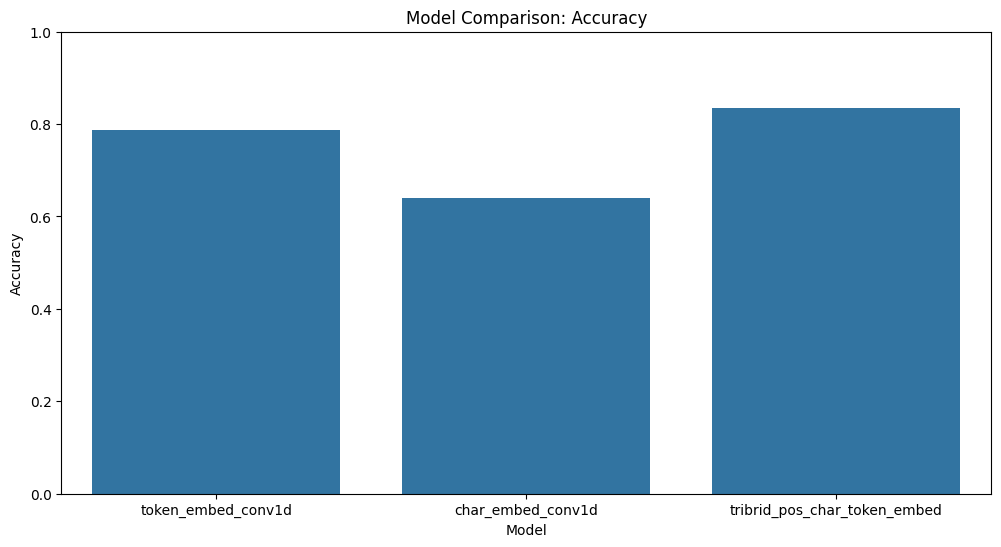

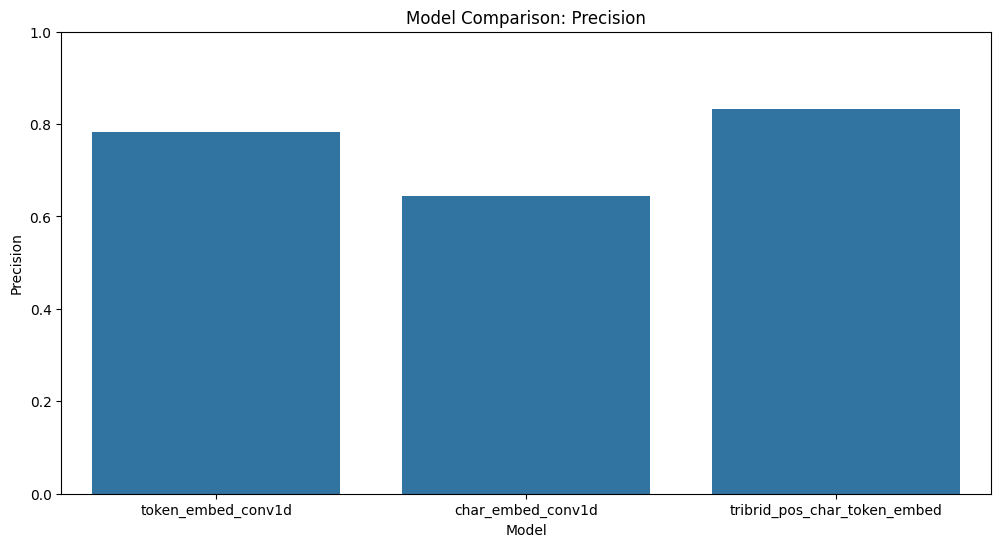

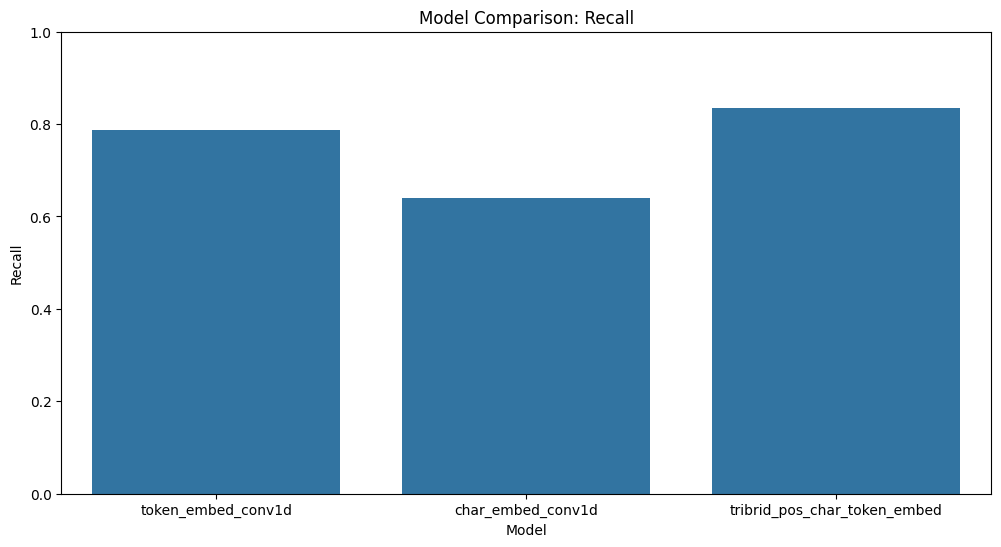

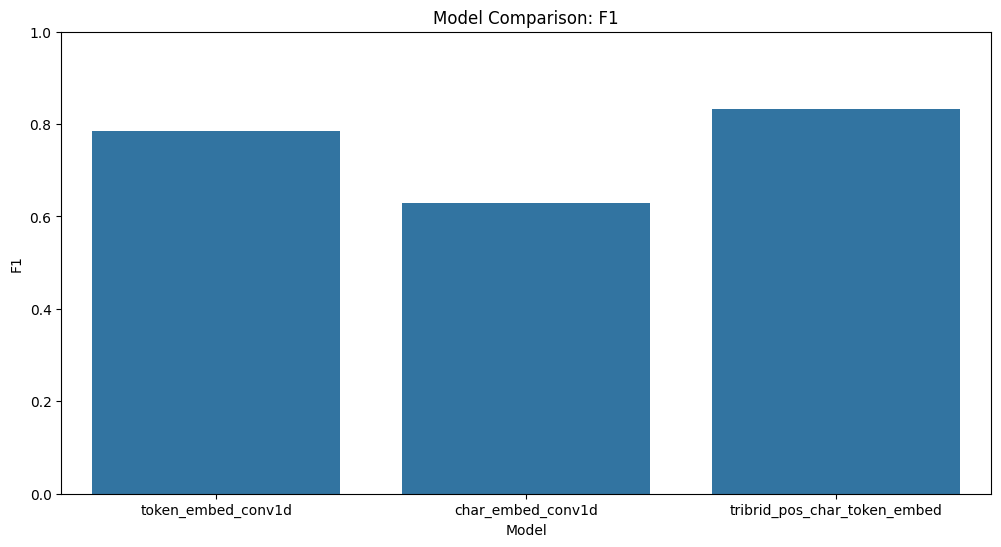

In [103]:
metrics = ["accuracy", "precision", "recall", "f1"]

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Model", y=metric, data=all_model_results)
    plt.title(f'Model Comparison: {metric.capitalize()}')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Model')
    plt.ylim(0, 1)
    plt.show()


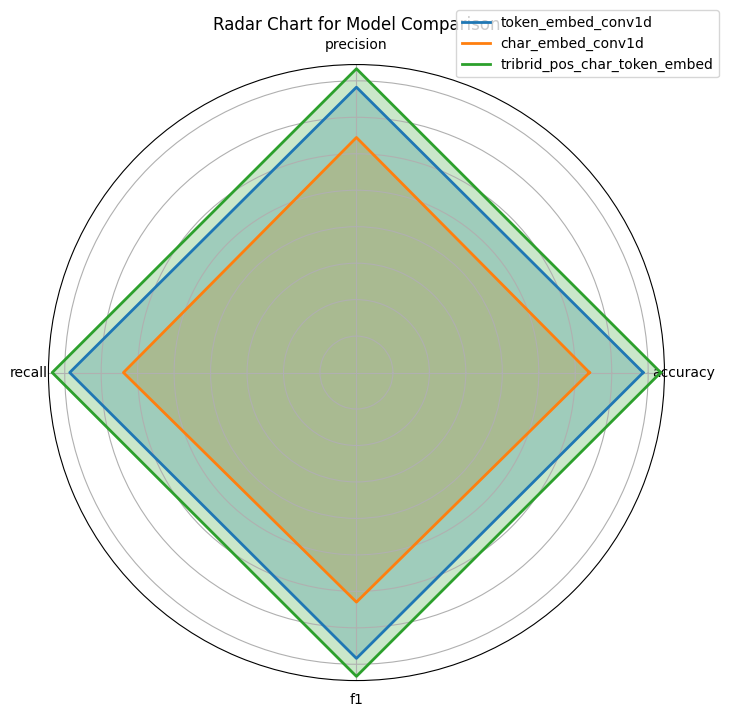

In [106]:


# Radar chart for comprehensive model comparison
labels = ["accuracy", "precision", "recall", "f1"]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(polar=True))

# Plot each model
for i, row in all_model_results.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=row['Model'])
    ax.fill(angles, values, alpha=0.25)

# Configure radar chart
ax.set_yticklabels([])  # Hide y-tick labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Radar Chart for Model Comparison')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


# **Save and load best performing model**

In [109]:
# Save best performing model to SavedModel format
model_3.save("medclassify_tribrid_model.keras")

In [110]:
# Save best performing model to SavedModel format
model_3.save("/content/drive/MyDrive/Projects_dl/MedClassify/medclassify_tribrid_model.keras")

In [123]:
import tensorflow_hub as hub  # Import tensorflow_hub
import tensorflow as tf
from tensorflow.keras import layers  # Import layers

# Load the model
model_path = "medclassify_tribrid_model.keras"
loaded_model = tf.keras.models.load_model(model_path,
                                          custom_objects={'KerasLayer': hub.KerasLayer},  # Pass hub.KerasLayer to custom_objects
                                          safe_mode=False)

# Manually rebuild the Lambda layer that uses hub.KerasLayer
for layer in loaded_model.layers:
    if isinstance(layer, layers.Lambda):
        # Rebuild Lambda layer using hub.KerasLayer
        layer.function = lambda x: hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                  trainable=False)(x)

# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)


945/945 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step


In [125]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoder,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.44035482589699,
 'precision': 0.8332207288313939,
 'recall': 0.8344035482589699,
 'f1': 0.8332187586725208}

In [127]:
# Compare loaded model results with original trained model results
np.isclose(list(model_3_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

# **Evaluate model on test dataset**

In [129]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [130]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step


In [131]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoder,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.79741164758586,
 'precision': 0.8263828297891344,
 'recall': 0.8279741164758586,
 'f1': 0.8266866120019807}

## **Make example predictions**

In [133]:
import json

with open("/content/drive/MyDrive/Projects_dl/MedClassify/medclassify_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)


In [134]:

abstracts = pd.DataFrame(example_abstracts)
abstracts

abstract  \
0  This RCT examined the efficacy of a manualized...   
1  Postpartum depression (PPD) is the most preval...   
2  Mental illness, including depression, anxiety ...   
3  Hepatitis C virus (HCV) and alcoholic liver di...   

                                      source  \
0  https://pubmed.ncbi.nlm.nih.gov/20232240/   
1  https://pubmed.ncbi.nlm.nih.gov/28012571/   
2  https://pubmed.ncbi.nlm.nih.gov/28942748/   
3  https://pubmed.ncbi.nlm.nih.gov/22244707/   

                                             details  
0  RCT of a manualized social treatment for high-...  
1  Formatting removed (can be used to compare mod...  
2               Effect of nutrition on mental health  
3  Baclofen promotes alcohol abstinence in alcoho...

In [135]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser


sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

In [136]:
# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [137]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [138]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)

In [139]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

In [140]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

In [141]:
# Make predictions on sample abstract features

test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [142]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)

In [143]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]

In [145]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
